In [1]:
import sys
import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes, make_grid

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)

Platform: win32
Python version: 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
---
CV2 version :  4.11.0
torch version :  2.5.1+cpu
torchvision version :  0.20.1+cpu


In [3]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [4]:
vehicle_data_dir =  Path("data", "train")

print("Data directory:", vehicle_data_dir)

Data directory: data\train


In [5]:
vehicle_files = list(vehicle_data_dir.iterdir())
vehicle_files[-5:]

[WindowsPath('data/train/fedcf2c1a78c1446_jpg.rf.jKHFjts8DglEwHYNbghh.xml'),
 WindowsPath('data/train/ff5b0ccc9d80b4ca_jpg.rf.2o3y0lxHb6wT4izSgIbb.jpg'),
 WindowsPath('data/train/ff5b0ccc9d80b4ca_jpg.rf.2o3y0lxHb6wT4izSgIbb.xml'),
 WindowsPath('data/train/ff5b0ccc9d80b4ca_jpg.rf.cac4097d732333daa8bd2da006418d09.jpg'),
 WindowsPath('data/train/ff5b0ccc9d80b4ca_jpg.rf.cac4097d732333daa8bd2da006418d09.xml')]

In [6]:
file_extension_counts = Counter(Path(file).suffix for file in vehicle_files)

for extension, count in file_extension_counts.items():
    print(f"Files with extension {extension}: {count}")

Files with extension .jpg: 878
Files with extension .xml: 878


In [7]:
images_dir = vehicle_data_dir / "images"
annotations_dir = vehicle_data_dir / "annotations"

images_dir.mkdir(exist_ok=True)
annotations_dir.mkdir(exist_ok=True)

In [8]:
for file in vehicle_files:
    if file.suffix.lower() in (".jpg", ".jpeg", ".png"):
        target_dir = images_dir
    elif file.suffix.lower() == ".xml":
        target_dir = annotations_dir
    file.rename(target_dir / file.name)

In [9]:
images_files = list(images_dir.iterdir())
annotations_files = list(annotations_dir.iterdir())

assert len(images_files) == len(annotations_files)

### Annotations

In [26]:
xml_filepath = annotations_dir / "07dfa70d0dfdf4e8_jpg.rf.3c08eaa4c5daa64b0072666a5e1cb090.xml"
with open(xml_filepath, 'r') as file:
    for _ in range(25):
        print(file.readline())

<annotation>

	<folder></folder>

	<filename>07dfa70d0dfdf4e8_jpg.rf.3c08eaa4c5daa64b0072666a5e1cb090.jpg</filename>

	<path>07dfa70d0dfdf4e8_jpg.rf.3c08eaa4c5daa64b0072666a5e1cb090.jpg</path>

	<source>

		<database>roboflow.ai</database>

	</source>

	<size>

		<width>416</width>

		<height>416</height>

		<depth>3</depth>

	</size>

	<segmented>0</segmented>

	<object>

		<name>Ambulance</name>

		<pose>Unspecified</pose>

		<truncated>0</truncated>

		<difficult>0</difficult>

		<occluded>0</occluded>

		<bndbox>

			<xmin>16</xmin>

			<xmax>62</xmax>

			<ymin>165</ymin>

			<ymax>238</ymax>

		</bndbox>



In [27]:
tree = ET.parse(xml_filepath)
root = tree.getroot()
print(root.tag)

annotation


In [28]:
width = int(root.find("size").find("width").text)
height = int(root.find("size").find("height").text)
print(f"image width: {width}  image height: {height}")

image width: 416  image height: 416


In [29]:
bounding_boxes = []
labels = []
for obj in root.findall("object"):
    label = obj.find("name").text
    labels.append(label)
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    bounding_boxes.append([xmin, ymin, xmax, ymax])

for label, bounding_box in zip(labels, bounding_boxes):
    print(f"{label}: {bounding_box}")

Ambulance: [16, 165, 62, 238]
Ambulance: [41, 163, 97, 251]
Ambulance: [78, 163, 137, 264]
Ambulance: [113, 160, 205, 284]
Ambulance: [185, 163, 275, 323]


### Bounding Boxes in PyTorch

In [30]:
bboxes_tensor = torch.tensor(bounding_boxes, dtype=torch.float)

print(bboxes_tensor)

tensor([[ 16., 165.,  62., 238.],
        [ 41., 163.,  97., 251.],
        [ 78., 163., 137., 264.],
        [113., 160., 205., 284.],
        [185., 163., 275., 323.]])


In [31]:
image_path = images_dir / '07dfa70d0dfdf4e8_jpg.rf.3c08eaa4c5daa64b0072666a5e1cb090.jpg'
image = read_image(str(image_path))
print(image.shape)

torch.Size([3, 416, 416])


In [32]:
image = draw_bounding_boxes(
    image=image,
    boxes=bboxes_tensor,
    labels=labels,
    width=3,
    fill=False,
    font="arial.ttf",
    font_size=10,
)

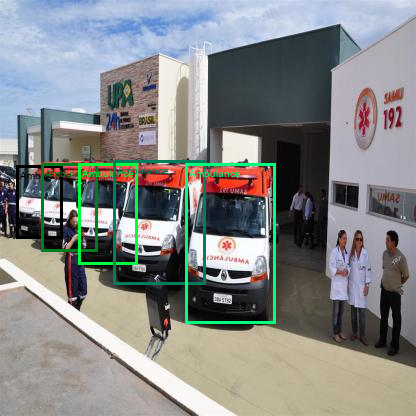

In [33]:
to_pil_image(image)

### Image Detection with YOLO

In [35]:
from ultralytics import YOLO

In [36]:
yolo = YOLO(task="detect", model="yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:06<00:00, 3.31MB/s]


In [37]:
yolo.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [38]:
yolo.names[5]

'bus'

In [39]:
class_assigned_to_23 = yolo.names[23]
print(f"{class_assigned_to_23} corresponds to 23")

giraffe corresponds to 23


In [40]:
classes_not_in_yolo = [
    "ambulance",
    "army vehicle",
    "auto rickshaw",
    "garbagevan",
    "human hauler",
    "minibus",
    "minivan",
    "pickup",
    "policecar",
    "rickshaw",
    "scooter",
    "suv",
    "taxi",
    "three wheelers (CNG)",
    "van",
    "wheelbarrow",
]

In [41]:
"ambulance" not in yolo.names.values()

True

In [42]:
image_path = images_dir / "63c912059a45468b_jpg.rf.213hdlwamCMKZuC4QTcA.jpg"

result = yolo(image_path)


image 1/1 C:\Users\Dickson\Vehicles\data\train\images\63c912059a45468b_jpg.rf.213hdlwamCMKZuC4QTcA.jpg: 640x640 4 persons, 4 cars, 4 trucks, 659.7ms
Speed: 11.2ms preprocess, 659.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


In [43]:
print(f"Type of result: {type(result)}")
print(f"Length of result: {len(result)}")

Type of result: <class 'list'>
Length of result: 1


In [45]:
image_path_task = images_dir / "068868f40fb6dbec_jpg.rf.TuNx4cAV28rilGbgRwVh.jpg"
result_task = yolo(image_path_task)

print(type(result_task))



image 1/1 C:\Users\Dickson\Vehicles\data\train\images\068868f40fb6dbec_jpg.rf.TuNx4cAV28rilGbgRwVh.jpg: 640x640 1 person, 2 cars, 8 trucks, 692.1ms
Speed: 10.1ms preprocess, 692.1ms inference, 24.3ms postprocess per image at shape (1, 3, 640, 640)
<class 'list'>


In [49]:
result = yolo.predict(image_path, conf=0.25, save=True, save_txt=True)


image 1/1 C:\Users\Dickson\Vehicles\data\train\images\63c912059a45468b_jpg.rf.213hdlwamCMKZuC4QTcA.jpg: 640x640 4 persons, 4 cars, 4 trucks, 689.8ms
Speed: 10.2ms preprocess, 689.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
2 labels saved to runs\detect\predict\labels


In [48]:
result_task = yolo.predict(image_path_task, conf=0.25, save=True, save_txt=True)


image 1/1 C:\Users\Dickson\Vehicles\data\train\images\068868f40fb6dbec_jpg.rf.TuNx4cAV28rilGbgRwVh.jpg: 640x640 1 person, 2 cars, 8 trucks, 798.9ms
Speed: 12.9ms preprocess, 798.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
2 labels saved to runs\detect\predict\labels


### Results from Running YOLO

In [50]:
result[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

In [51]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 7., 2., 0., 0., 0., 7., 7., 2., 7., 0.])
conf: tensor([0.8898, 0.8009, 0.7966, 0.7179, 0.6211, 0.6183, 0.6125, 0.5766, 0.3962, 0.3553, 0.2565, 0.2531])
data: tensor([[1.8917e+02, 1.6835e+02, 2.4369e+02, 2.1915e+02, 8.8981e-01, 2.0000e+00],
        [1.4429e+02, 1.6083e+02, 1.8743e+02, 2.1111e+02, 8.0087e-01, 2.0000e+00],
        [2.7954e+02, 1.1715e+02, 3.3645e+02, 2.0985e+02, 7.9657e-01, 7.0000e+00],
        [6.7130e+01, 1.6835e+02, 1.0956e+02, 2.1139e+02, 7.1785e-01, 2.0000e+00],
        [1.3487e+01, 1.6211e+02, 2.5518e+01, 2.0785e+02, 6.2109e-01, 0.0000e+00],
        [5.0031e+01, 1.6583e+02, 6.5334e+01, 2.1091e+02, 6.1827e-01, 0.0000e+00],
        [3.0810e+01, 1.6761e+02, 4.1882e+01, 2.0836e+02, 6.1248e-01, 0.0000e+00],
        [3.5185e+02, 1.2272e+02, 4.1584e+02, 2.6568e+02, 5.7655e-01, 7.0000e+00],
        [3.4645e+02, 4.5612e+01, 4.1577e+02, 2.6969e+02, 3.9619e-01, 7.0000e+00],
        [3.3370e+02, 1.60

In [52]:
print(result[0].boxes.cls)
print(f"Number of objects detected: {len(result[0].boxes.cls)}")

tensor([2., 2., 7., 2., 0., 0., 0., 7., 7., 2., 7., 0.])
Number of objects detected: 12


In [53]:
number_of_detected_objs = len(result_task[0].boxes.cls)
print(f"Number of objects detected in frame_2574.jpg: {number_of_detected_objs}")

Number of objects detected in frame_2574.jpg: 11


In [54]:
object_counts = Counter([yolo.names[int(cls)] for cls in result[0].boxes.cls])
object_counts

Counter({'car': 4, 'truck': 4, 'person': 4})

In [55]:
object_counts_task =Counter(
    [yolo.names[int(cls)] for cls in result_task[0].boxes.cls]

)    

most_common_class, count_of_class = object_counts_task.most_common(n=1)[0]
print(f"Most common class: {most_common_class}")
print(f"Number of detected {most_common_class}: {count_of_class}")

Most common class: truck
Number of detected truck: 8


In [56]:
print(result[0].boxes.conf)
print(f"Number of objects detected: {len(result[0].boxes.conf)}")

tensor([0.8898, 0.8009, 0.7966, 0.7179, 0.6211, 0.6183, 0.6125, 0.5766, 0.3962, 0.3553, 0.2565, 0.2531])
Number of objects detected: 12


In [57]:
length_of_confidence_tensor = len(result_task[0].boxes.conf)
print(f"Number of objects detected: {length_of_confidence_tensor}")

Number of objects detected: 11


In [59]:
number_of_confident_objects = (result[0].boxes.conf > 0.50).sum().item()
print(f"Number of objects detected with 25% confidence: {number_of_confident_objects}")

Number of objects detected with 50% confidence: 8


In [62]:
number_of_confident_objects_task = (result_task[0].boxes.conf > 0.50).sum().item()

print(
    f"Number of objects detected in frame_2575.jpg with 25% confidence: {number_of_confident_objects_task}")

Number of objects detected in frame_2575.jpg with 25% confidence: 8


In [63]:
result[0].boxes.xywh

tensor([[216.4314, 193.7466,  54.5234,  50.8002],
        [165.8598, 185.9694,  43.1406,  50.2841],
        [307.9975, 163.4987,  56.9131,  92.6957],
        [ 88.3463, 189.8721,  42.4328,  43.0401],
        [ 19.5026, 184.9795,  12.0310,  45.7406],
        [ 57.6821, 188.3699,  15.3030,  45.0825],
        [ 36.3457, 187.9845,  11.0719,  40.7439],
        [383.8436, 194.2043,  63.9950, 142.9610],
        [381.1088, 157.6532,  69.3262, 224.0815],
        [342.8236, 179.8018,  18.2455,  38.4043],
        [342.6036, 179.7187,  17.8650,  37.1206],
        [ 68.5855, 183.8084,   7.5630,  31.8363]])

In [64]:
result[0].orig_shape

(416, 416)

In [65]:
result[0].boxes.xywhn[0]

tensor([0.5203, 0.4657, 0.1311, 0.1221])

In [66]:
result[0].boxes.xywh[0] / torch.Tensor([640, 360, 640, 360])

tensor([0.3382, 0.5382, 0.0852, 0.1411])

In [67]:
original_shape_task = result_task[0].orig_shape
print(f"Original shape of frame_2574.jpg: {original_shape_task}")

Original shape of frame_2574.jpg: (416, 416)


In [68]:
normalized_xywh = result_task[0].boxes.xywh
print(f"Normalized xywh bounding box for frame_2575.jpg: {normalized_xywh[0]}")

Normalized xywh bounding box for frame_2575.jpg: tensor([334.8400, 389.2964,  88.3526,  52.9493])


In [70]:
normalized_xywh_task =(
    result_task[0].boxes.xywh[0] / torch.Tensor([640, 360, 640, 360])

)
print(f"Normalized xywh bounding box for frame_2575.jpg: {normalized_xywh[0]}")

Normalized xywh bounding box for frame_2575.jpg: tensor([334.8400, 389.2964,  88.3526,  52.9493])


In [71]:
result[0].boxes.xyxy

tensor([[189.1696, 168.3465, 243.6931, 219.1467],
        [144.2895, 160.8273, 187.4301, 211.1114],
        [279.5409, 117.1509, 336.4541, 209.8466],
        [ 67.1299, 168.3521, 109.5627, 211.3922],
        [ 13.4871, 162.1091,  25.5181, 207.8498],
        [ 50.0305, 165.8287,  65.3336, 210.9111],
        [ 30.8098, 167.6126,  41.8817, 208.3565],
        [351.8461, 122.7238, 415.8411, 265.6848],
        [346.4457,  45.6124, 415.7719, 269.6939],
        [333.7008, 160.5996, 351.9463, 199.0039],
        [333.6711, 161.1584, 351.5361, 198.2790],
        [ 64.8040, 167.8903,  72.3670, 199.7266]])

In [72]:
result[0].boxes.xyxyn

tensor([[0.4547, 0.4047, 0.5858, 0.5268],
        [0.3468, 0.3866, 0.4506, 0.5075],
        [0.6720, 0.2816, 0.8088, 0.5044],
        [0.1614, 0.4047, 0.2634, 0.5082],
        [0.0324, 0.3897, 0.0613, 0.4996],
        [0.1203, 0.3986, 0.1571, 0.5070],
        [0.0741, 0.4029, 0.1007, 0.5009],
        [0.8458, 0.2950, 0.9996, 0.6387],
        [0.8328, 0.1096, 0.9995, 0.6483],
        [0.8022, 0.3861, 0.8460, 0.4784],
        [0.8021, 0.3874, 0.8450, 0.4766],
        [0.1558, 0.4036, 0.1740, 0.4801]])

In [73]:
location_of_results = Path(result[0].save_dir)

print(f"Results saved to {location_of_results}")
location_of_results.exists()

Results saved to runs\detect\predict


True

In [74]:
location_of_results_task = result_task[0].save_dir
print(f"Results for frame_2575.jpg saved to {location_of_results_task}")

Results for frame_2575.jpg saved to runs\detect\predict


In [75]:
result[0].speed

{'preprocess': 10.24150000012014,
 'inference': 689.8160000000644,
 'postprocess': 2.483899999788264}

In [76]:
print(f"Total time in milliseconds: {sum(result[0].speed.values())}")

Total time in milliseconds: 702.5413999999728


In [77]:
total_time = sum(result_task[0].speed.values())
print(f"Total time in milliseconds: {total_time}")

Total time in milliseconds: 814.5977000003768


### Displaying Bounding Box

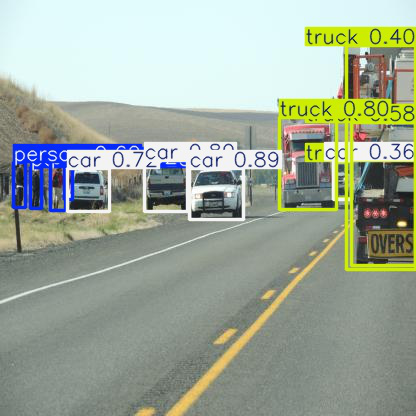

In [79]:
Image.open(location_of_results / "63c912059a45468b_jpg.rf.213hdlwamCMKZuC4QTcA.jpg")

In [80]:
images_dir

WindowsPath('data/train/images')

In [81]:
Path(location_of_results_task)

WindowsPath('runs/detect/predict')

In [82]:
location_of_results_task = Path(location_of_results_task)

In [83]:
location_of_results_task

WindowsPath('runs/detect/predict')

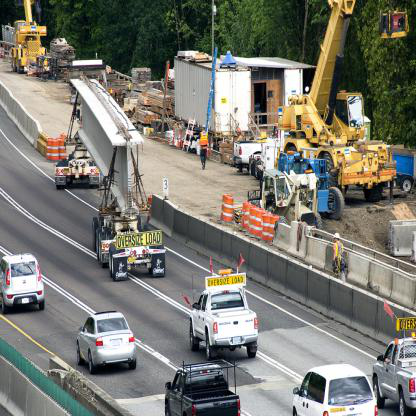

In [84]:
Image.open(images_dir / '068868f40fb6dbec_jpg.rf.TuNx4cAV28rilGbgRwVh.jpg')

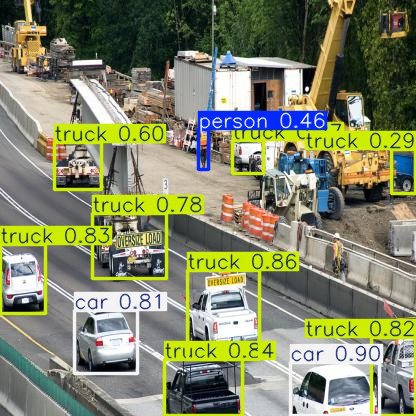

In [85]:
Image.open(location_of_results_task / '068868f40fb6dbec_jpg.rf.TuNx4cAV28rilGbgRwVh.jpg')

In [86]:
with (location_of_results / "labels" / "63c912059a45468b_jpg.rf.213hdlwamCMKZuC4QTcA.txt").open("r") as f:
    print(f.read())

2 0.520268 0.465737 0.131066 0.122116
2 0.398701 0.447042 0.103703 0.120875
7 0.740379 0.393026 0.13681 0.222826
2 0.212371 0.456423 0.102002 0.103462
0 0.0468812 0.444662 0.0289206 0.109953
0 0.138659 0.452812 0.0367861 0.108371
0 0.0873696 0.451886 0.026615 0.0979421
7 0.922701 0.466837 0.153834 0.343656
2 0.520268 0.465737 0.131066 0.122116
2 0.398701 0.447042 0.103703 0.120875
7 0.740379 0.393026 0.13681 0.222826
2 0.212371 0.456423 0.102002 0.103462
0 0.0468812 0.444662 0.0289206 0.109953
0 0.138659 0.452812 0.0367861 0.108371
0 0.0873696 0.451886 0.026615 0.0979421
7 0.922701 0.466837 0.153834 0.343656
7 0.916127 0.378974 0.16665 0.538657
2 0.824095 0.432216 0.0438593 0.0923181
7 0.823566 0.432016 0.0429447 0.0892323
0 0.164869 0.441847 0.0181802 0.0765297



In [87]:
with (location_of_results / "labels" / "068868f40fb6dbec_jpg.rf.TuNx4cAV28rilGbgRwVh.txt").open("r") as f:
    print(f.read())

2 0.804904 0.935809 0.212386 0.127282
7 0.537793 0.757183 0.17357 0.214816
7 0.488029 0.932182 0.187416 0.134896
7 0.0546532 0.671126 0.109051 0.167013
7 0.946464 0.904988 0.106018 0.189195
2 0.254819 0.82181 0.150649 0.152512
7 0.310896 0.591984 0.178363 0.156015
7 0.186965 0.399188 0.113148 0.11352
2 0.804904 0.935809 0.212386 0.127282
7 0.537793 0.757183 0.17357 0.214816
7 0.488029 0.932182 0.187416 0.134896
7 0.0546532 0.671126 0.109051 0.167013
7 0.946464 0.904988 0.106018 0.189195
2 0.254819 0.82181 0.150649 0.152512
7 0.310896 0.591984 0.178363 0.156015
7 0.186965 0.399188 0.113148 0.11352
0 0.488748 0.359566 0.022654 0.0977723
7 0.970563 0.411739 0.0578412 0.106985
7 0.595455 0.377093 0.074984 0.0785331

